## Module Title:	 Data Visualization Techniques  & Machine Learning for Business 
### Assessment Title: Integrated CA
### Lecturer Name:	 David McQuaid  & PhD Muhammad Iqbal
### Student Full Name & Student ID:	Natalia de Oliveira Rodrigues 2023112

### GitHub Repository: 
https://github.com/norodrigues111/Recommendation-System-and-Market-Basket-Analysis.git

### Dataset Source:
https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba

This academic project aims to delivery a critical analysis of the knowledge produced, in the course: Higher Diploma in Science in Data Analytics for Business at CCT College.

In [1]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import asarray
import statistics as stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Groceries data.csv')

# Exploratory Data Analysis (EDA)

In [3]:
def glimpse(df):
    print(f'Observations: {df.shape[0]} rows \nAttributes: {df.shape[1]} columns')
    print("-" * 100)
    display(df.head())
    print("-" * 100)
    display(df.describe())
    print("-" * 100)
    display(f'Missing values: {df.isnull().sum().sum()}')
    print("-" * 100)
    display(df.info())
    
df = df
glimpse(df)

Observations: 38765 rows 
Attributes: 7 columns
----------------------------------------------------------------------------------------------------


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


----------------------------------------------------------------------------------------------------


,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


----------------------------------------------------------------------------------------------------


'Missing values: 0'

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


None

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [70]:
# Widget for selecting the time granularity
granularity_widget = widgets.Dropdown(
    options=['day', 'day_of_week', 'month', 'year'],
    value='day',
    description='Granularity:'
)

def plot_items_sold(df, granularity):
    # Create a new DataFrame with aggregated values based on the selected granularity
    if granularity == 'day':
        df_aggregated = df.groupby('Date').size().reset_index(name='Count')
    elif granularity == 'day_of_week':
        df_aggregated = df.groupby('day_of_week').size().reset_index(name='Count')
    elif granularity == 'month':
        df_aggregated = df.groupby('month').size().reset_index(name='Count')
    elif granularity == 'year':
        df_aggregated = df.groupby('year').size().reset_index(name='Count')

    # Plot using Plotly for interactive plots
    x_column = 'Date' if granularity == 'day' else granularity  # Correct x-column based on granularity

    if granularity in ['day', 'day_of_week', 'month']:
        fig = px.line(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')
    elif granularity in ['year']:
        fig = px.bar(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')

    fig.update_xaxes(title_text='Time')
    fig.update_yaxes(title_text='Number of Items Sold')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(granularity=granularity_widget)
def interactive_plot(granularity):
    plot_items_sold(df, granularity)

interactive(children=(Dropdown(description='Granularity:', options=('day', 'day_of_week', 'month', 'year'), va…

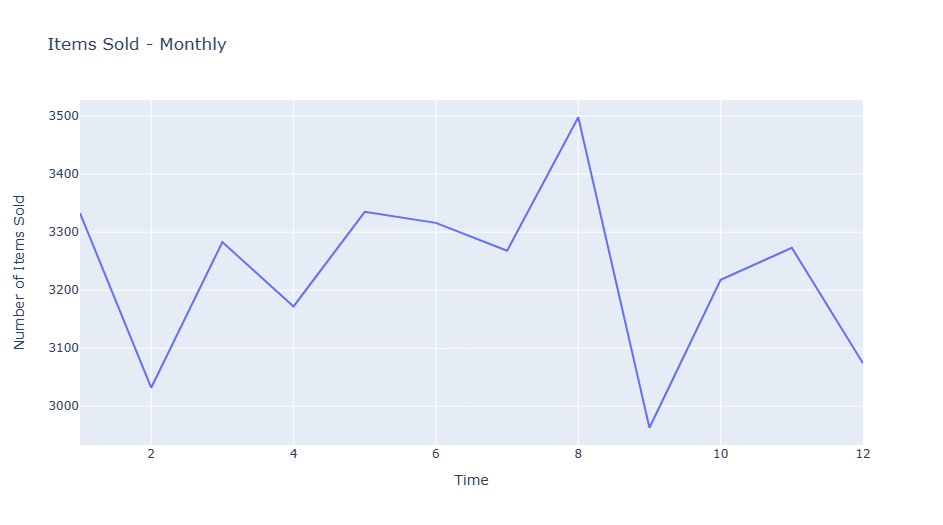

In [6]:
# Widget for selecting the year
year_widget = widgets.Dropdown(
    options=['2014', '2015', 'All'],
    value='All',
    description='Year:'
)

def plot_top_items(df, year):
    # Filter data based on the selected year
    if year == 'All':
        df_filtered = df
    else:
        df_filtered = df[df['year'] == int(year)]

    # Group by itemDescription and calculate the sum of sales
    top_items = df_filtered.groupby('itemDescription').size().reset_index(name='Count')
    
    # Sort in descending order
    top_items = top_items.sort_values(by='Count', ascending=False).head(10)

    # Reverse the order of bars
    top_items = top_items[::-1]

    # Plot using Plotly for interactive horizontal bar chart
    fig = px.bar(
        top_items,
        x='Count',
        y='itemDescription',
        orientation='h',
        title=f'Top 10 Items Sold - {year}' if year != 'All' else 'Top 10 Items Sold - All Period'
    )
    fig.update_xaxes(title_text='Number of Items Sold')
    fig.update_yaxes(title_text='Item Description')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(year=year_widget)
def interactive_top_items(year):
    plot_top_items(df, year)

interactive(children=(Dropdown(description='Year:', index=2, options=('2014', '2015', 'All'), value='All'), Ou…

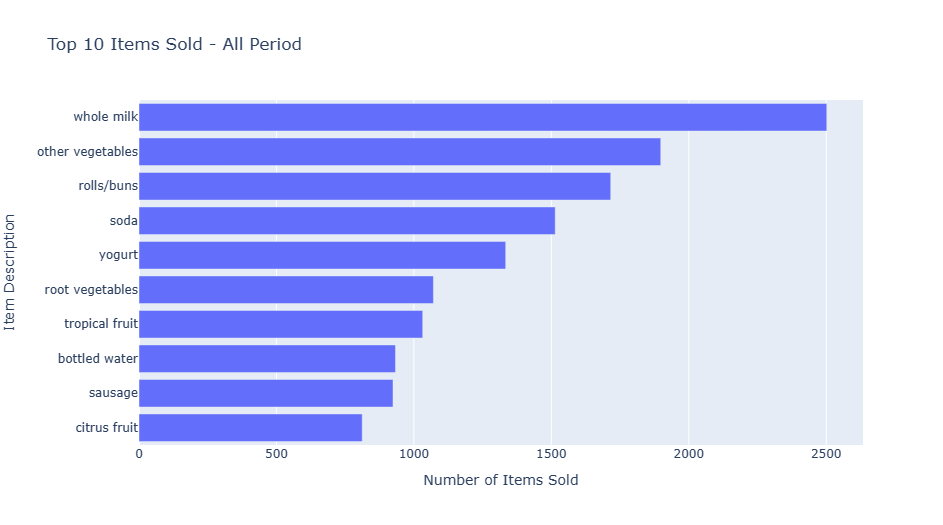

## Continuous Assessment 

### 1.1 Discuss and explain the purpose of a recommendation system for online retail business in machine learning. 

According to (Wikipedia Contributors, 2019), online retail, also well known as eCommerce, allows customers to buy goods or services using web-based technology. Electronic Commerce permit businesses all over the world, the opportunity to collect customers' data. Technology makes possible to build customers’ profiles based on demographic data, purchase history, preferences, and active data such as likes, views, clicks, and time spent. 

AI has helped businesses to build powerful analytics tools to improve customer satisfaction and drive revenue.  Recommendation Systems enable businesses to learn about their customers, and so provide more meaningful content, increasing customer satisfaction, and drive business revenue. 

Industry leaders in online retail are using recommendation systems. Amazon’s recommendations are responsible for 35% of revenue, Netflix’s recommendations are responsible for 75% of the movies seen on the platform, and 60% of the videos watched on YouTube were recommended to their customers.

Recommendation engines enable customers to find goods or services using different algorithms. They are: Contant-based filtering, based on item features and user profile data; Collaborative-based filtering, based on the similarity with other users (user-to-user or item-to-item); and Hybrid systems that combine Contant-based filtering, and Collaborative-based filtering.


### 1.2)	Briefly compare Content and Collaborative filtering using any dataset of your choice. Train and test machine learning models for the user-user or item-item collaborative filtering. 

### Output the shape of tfidf_matrix = tfidf_matrix.shape
From the above output, you observe that 38,765 different vocabularies or words in your dataset have 188 items.

# Data Preparation

In [7]:
rs_df = df.copy()

In [8]:
rs_df['Quantity'] = 1

In [9]:
len(pd.unique(rs_df.itemDescription))

167

In [10]:
# Pivot the DataFrame from long to wide format
dataWide = rs_df.pivot_table(index='Member_number', columns='itemDescription', values='Quantity', aggfunc='sum', fill_value=0)

In [11]:
dataWide.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [12]:
dataWide[dataWide.index==1000]

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0


In [13]:
dataWide.loc[1000,:]

itemDescription
Instant food products    0
UHT-milk                 0
abrasive cleaner         0
artif. sweetener         0
baby cosmetics           0
                        ..
white bread              0
white wine               0
whole milk               2
yogurt                   1
zwieback                 0
Name: 1000, Length: 167, dtype: int64

# Item-based Collaborative Filtering

In item based collaborative filtering we do not care about the user column

In [71]:
#Drop the Person column
data_cf = dataWide.copy()

In [72]:
data_cf.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [73]:
data_cf = data_cf.reset_index()
data_cf.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1,1001,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,2,0,0
2,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [74]:
#Drop the Person column
#data_ib = data_ib.iloc[:,1:]
data_cf = data_cf.drop("Member_number", axis=1)
data_cf.tail()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
3893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,0,0,0,0,0,0,0,0,0,2,...,0,0,0,1,0,0,0,0,1,0
3897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# Create a placeholder dataframe listing item vs. item
data_icf = pd.DataFrame(index=data_cf.columns,columns=data_cf.columns)

data_icf.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
itemDescription,,,,,,,,,,,,,,,,,,,,,
Instant food products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UHT-milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abrasive cleaner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artif. sweetener,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baby cosmetics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
from scipy.spatial.distance import cosine
for i in range(0,len(data_icf.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(data_icf.columns)) :
      # Fill in placeholder with cosine similarities
      data_icf.iloc[i,j] = 1-cosine(data_cf.iloc[:,i],data_cf.iloc[:,j])

In [77]:
data_sims1 = dataWide.reset_index()

In [78]:
data_sims1.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
1,1001,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,2,0,0
2,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [79]:
# Create a place holder matrix for similarities, and fill in the user name column
data_sims = pd.DataFrame(index=data_sims1.index,columns=data_sims1.columns)
data_sims.iloc[:,:1] = data_sims1.iloc[:,:1]

In [80]:
#This is the same as our original data but with nothing filled in except the headers
data_sims.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
data_neighbours = pd.DataFrame(index=data_icf.columns,columns=range(1,7))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(data_icf.columns)):
    data_neighbours.iloc[i,:6] = data_icf.iloc[0:,i].sort_values(ascending=False)[:6].index

In [82]:
# Print a sample
data_neighbours.iloc[:,1:6]

,2,3,4,5,6
itemDescription,,,,,
Instant food products,root vegetables,margarine,soda,whole milk,chocolate
UHT-milk,other vegetables,whole milk,rolls/buns,soda,tropical fruit
abrasive cleaner,frozen potato products,meat spreads,spread cheese,sausage,other vegetables
artif. sweetener,baby cosmetics,make up remover,bottled water,whole milk,instant coffee
baby cosmetics,skin care,artif. sweetener,oil,frankfurter,frozen dessert
...,...,...,...,...,...
white bread,whole milk,rolls/buns,other vegetables,soda,whipped/sour cream
white wine,whole milk,soda,sausage,yogurt,rolls/buns
whole milk,other vegetables,rolls/buns,yogurt,soda,tropical fruit


In [83]:
# Specify the index you want to retrieve attributes for
selected_index = 'yogurt'

# Get the list of 5 attributes for the specified index
attributes_list = data_neighbours.loc[selected_index] #.tolist()

# Print the result
print(f"Attributes for '{selected_index}':")
attributes_list[1:6]

Attributes for 'yogurt':


2          whole milk
3    other vegetables
4          rolls/buns
5                soda
6             sausage
Name: yogurt, dtype: object

# Item-based Contant Filtering

In [14]:
rs_df.head(3)

,Member_number,Date,itemDescription,year,month,day,day_of_week,Quantity
0,1808,2015-07-21,tropical fruit,2015,7,21,1,1
1,2552,2015-05-01,whole milk,2015,5,1,4,1
2,2300,2015-09-19,pip fruit,2015,9,19,5,1


In [15]:
# Replace NaN with an empty string
rs_df['itemDescription'] = rs_df['itemDescription'].fillna('')

In [16]:
rs_df

,Member_number,Date,itemDescription,year,month,day,day_of_week,Quantity
0,1808,2015-07-21,tropical fruit,2015,7,21,1,1
1,2552,2015-05-01,whole milk,2015,5,1,4,1
2,2300,2015-09-19,pip fruit,2015,9,19,5,1
3,1187,2015-12-12,other vegetables,2015,12,12,5,1
4,3037,2015-01-02,whole milk,2015,1,2,4,1
...,...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6,1
38761,2022,2014-02-23,candy,2014,2,23,6,1
38762,1097,2014-04-16,cake bar,2014,4,16,2,1
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2,1


In [17]:
# Concatenate 'itemDescription' for each 'Member_number' and remove special characters
def concatenate_and_remove_special_chars(x):
    concatenated = ', '.join(x)
    return ''.join(e for e in concatenated if e.isalnum() or e.isspace())

# Apply the aggregation function
contant_df = rs_df.groupby('Member_number')['itemDescription'].agg(concatenate_and_remove_special_chars).reset_index()

# Display the result
contant_df

,Member_number,itemDescription
0,1000,soda canned beer sausage sausage whole milk wh...
1,1001,frankfurter frankfurter beef sausage whole mil...
2,1002,tropical fruit butter milk butter frozen veget...
3,1003,sausage root vegetables rollsbuns detergent fr...
4,1004,other vegetables pip fruit root vegetables can...
...,...,...
3893,4996,dessert salty snack rollsbuns misc beverages b...
3894,4997,tropical fruit white wine whole milk curd grap...
3895,4998,rollsbuns curd
3896,4999,bottled water butter milk tropical fruit berri...


In [18]:
contant_df.head(1)['itemDescription']

0    soda canned beer sausage sausage whole milk wh...
Name: itemDescription, dtype: object

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
contant_df['itemDescription'] = contant_df['itemDescription'].fillna('')

In [20]:
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(contant_df['itemDescription'])

In [21]:
tfv_matrix

<3898x6731 sparse matrix of type '<class 'numpy.float64'>'
	with 124418 stored elements in Compressed Sparse Row format>

In [22]:
tfv_matrix.shape

(3898, 6731)

In [23]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [24]:
sig[0]

array([0.76165654, 0.76159797, 0.76159513, ..., 0.76159416, 0.76159709,
       0.76159855])

In [25]:
# Reverse mapping of indices and movie titles
indices = pd.Series(contant_df.index, index=contant_df['Member_number']).drop_duplicates()

In [26]:
indices

Member_number
1000       0
1001       1
1002       2
1003       3
1004       4
        ... 
4996    3893
4997    3894
4998    3895
4999    3896
5000    3897
Length: 3898, dtype: int64

In [27]:
indices[1000]

0

In [28]:
sig[0]

array([0.76165654, 0.76159797, 0.76159513, ..., 0.76159416, 0.76159709,
       0.76159855])

In [29]:
list(enumerate(sig[indices[1000]]))

[(0, 0.7616565429450619),
 (1, 0.7615979651329087),
 (2, 0.7615951316760668),
 (3, 0.7615952968105872),
 (4, 0.7615986905670984),
 (5, 0.7615941559557649),
 (6, 0.7615950633510026),
 (7, 0.7615950224839837),
 (8, 0.7615957935730526),
 (9, 0.7615941559557649),
 (10, 0.7615954404025423),
 (11, 0.7615954180890334),
 (12, 0.7615951967905865),
 (13, 0.7616033802941464),
 (14, 0.7615973485252293),
 (15, 0.76159441704739),
 (16, 0.7615955928007467),
 (17, 0.7615952213275392),
 (18, 0.7615941559557649),
 (19, 0.7615967529377113),
 (20, 0.7615945023242766),
 (21, 0.7615955494036593),
 (22, 0.7615956710005458),
 (23, 0.7615947967785871),
 (24, 0.7615955978131776),
 (25, 0.7615990525323605),
 (26, 0.7615946530709585),
 (27, 0.7615956375590248),
 (28, 0.7615941559557649),
 (29, 0.7615951882994264),
 (30, 0.761595884328687),
 (31, 0.7615963844400347),
 (32, 0.7615944097689189),
 (33, 0.7615976068582594),
 (34, 0.7615941559557649),
 (35, 0.7615958188842967),
 (36, 0.7615952169132859),
 (37, 0.761600

In [30]:
def give_rec(Member_number, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[Member_number]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:6]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return df['itemDescription'].iloc[movie_indices]

In [31]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec(1000)

1953       canned beer
3100       frankfurter
391             yogurt
2516      bottled beer
2203    tropical fruit
Name: itemDescription, dtype: object

 # Item-based Contant Filtering

In [32]:
rs_df

,Member_number,Date,itemDescription,year,month,day,day_of_week,Quantity
0,1808,2015-07-21,tropical fruit,2015,7,21,1,1
1,2552,2015-05-01,whole milk,2015,5,1,4,1
2,2300,2015-09-19,pip fruit,2015,9,19,5,1
3,1187,2015-12-12,other vegetables,2015,12,12,5,1
4,3037,2015-01-02,whole milk,2015,1,2,4,1
...,...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6,1
38761,2022,2014-02-23,candy,2014,2,23,6,1
38762,1097,2014-04-16,cake bar,2014,4,16,2,1
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2,1


In [33]:
rs_df.head()['itemDescription']

0      tropical fruit
1          whole milk
2           pip fruit
3    other vegetables
4          whole milk
Name: itemDescription, dtype: object

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
rs_df['itemDescription'] = rs_df['itemDescription'].fillna('')

In [35]:
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(rs_df['itemDescription'])

In [36]:
tfv_matrix

<38765x310 sparse matrix of type '<class 'numpy.float64'>'
	with 85051 stored elements in Compressed Sparse Row format>

In [37]:
tfv_matrix

<38765x310 sparse matrix of type '<class 'numpy.float64'>'
	with 85051 stored elements in Compressed Sparse Row format>

In [38]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [39]:
sig[0]

array([0.76294559, 0.76159416, 0.7618768 , ..., 0.76159416, 0.76177271,
       0.76159416])

In [67]:
# Reverse mapping of indices and movie titles
indices = pd.Series(rs_df.index, index=rs_df[['Member_number','itemDescription']]).drop_duplicates()

AttributeError: 'list' object has no attribute 'columns'

In [68]:
indices

(1808, tropical fruit)               0
(2552, whole milk)                   1
(2300, pip fruit)                    2
(1187, other vegetables)             3
(3037, whole milk)                   4
                                 ...  
(4471, sliced cheese)            38760
(2022, candy)                    38761
(1097, cake bar)                 38762
(1510, fruit/vegetable juice)    38763
(1521, cat food)                 38764
Length: 38765, dtype: int64

In [55]:
indices[(2552, 'whole milk')]

(2552, whole milk)        1
(2552, whole milk)    27510
dtype: int64

In [57]:
n_idx = indices[(2552, 'whole milk')]

In [48]:
sig[n_idx]

array([[0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
        0.76159416]])

In [58]:
list(enumerate(sig[indices[(2552, 'whole milk')]]))

[(0,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416])),
 (1,
  array([0.76159416, 0.76294559, 0.76159416, ..., 0.76159416, 0.76159416,
         0.76159416]))]

In [60]:
def give_rec(Member_number,itemDescription, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title].iloc[0]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    item_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return rs_df['itemDescription'].iloc[item_indices]

In [61]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec(2552,'whole milk')

NameError: name 'title' is not defined

### 1.3)	Justify your recommendations for the considered scenario by providing a conceptual insight. 

### 2.1) Perform Market Basket Analysis on the chosen dataset by using Apriori and FP growth algorithms.

### 2.2) Can you express the major divergence between these models? Compare and contrast the machine learning results obtained based on both algorithms. 

### 3.1) Create an interactive Dashboard aimed at older adults (65+) with specific features to summarise the most important aspects of the data and identify through your visualisation why this dataset is suitable for Machine Learning models in an online retail business. 

### 3.2) Explain how your dashboard is designed with this demographic in mind.